**Install and import dependencies**


In [174]:
from obspy import read

**Replace file_name with the path to the SEGY file in the Dixondale folder**

In [189]:
dixondale = "G:/3D Seismic Volumes-SEGY/Seismic Data 3DX/Dixondale/DixondalePSTM_8-14-19_filtered_export3.sgy"

netherlands = "./SeismicData/Netherlands.sgy"


stream = read(dixondale, format="SEGY")
stream.normalize()

600515 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.844000Z | 250.0 Hz, 462 samples
...
(600513 other traces)
...
Seq. No. in line:  577 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:01.844000Z | 250.0 Hz, 462 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [190]:
import numpy as np

def get_FFID(trace):
    header = trace.stats.segy.trace_header
    return int.from_bytes(header.unpacked_header[8:12], byteorder="little" if header.endian=="<" else "big")

min_FFID = float("inf")
max_FFID = -float("inf")

for trace in stream:
    ffid = get_FFID(trace)
    if ffid>max_FFID:
        max_FFID = ffid
    elif ffid<min_FFID:
        min_FFID = ffid

num_inlines = [0]
last_ffid = get_FFID(stream[0])

traces = []
for trace in stream:
    traces.append(trace.data)
    ffid = get_FFID(trace)
    if ffid!=last_ffid:
        num_inlines.append(0)
    num_inlines[-1] += 1
    last_ffid = ffid
num_inlines = np.bincount(num_inlines).argmax()
num_crosslines = len(stream)//num_inlines
sample_depth = len(stream[0])


seismic_array = []
last_inline = 0
for ct, trace in enumerate(traces):
    if ct%num_inlines==0:
        seismic_array.append([])
    seismic_array[-1].append(trace)


if(len(seismic_array[-1])!=num_inlines):
    seismic_array.pop()


seismic_array = np.array(seismic_array)
print(seismic_array.shape)

(631, 951, 462)


(631, 951, 462)


Text(0, 0.5, 'Depth')

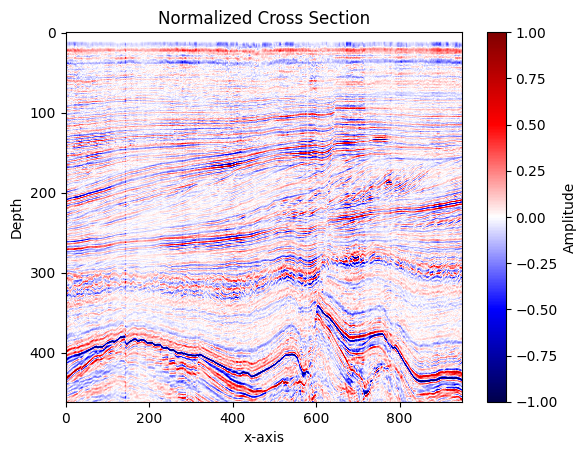

In [192]:
import matplotlib.pyplot as plt

print(seismic_array.shape)

plt.imshow(np.flipud(np.rot90(seismic_array[180])), cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section")
plt.xlabel("x-axis")
plt.ylabel("Depth")



**Convert into Numpy array with axes as (depth, crossline, inline)**

In [3]:
from preprocessing import to3dArray, pad_or_crop_3d_array

print("Normalizing amplitude data...")
stream.normalize()

print("Converting volume to 3D array")
seismic_array = to3dArray(stream)

print("Volume dimensions:", str(seismic_array.shape))

for ct, i in enumerate(seismic_array.shape):
    if i<=1:
        msg = f"Axis {ct+1} has length of {i}. Ensure the file was exported with marked inlines"
        warnings.warn(msg)



Normalizing amplitude data...


c:\Users\PangD\Desktop\SeismicML\.venv\lib\site-packages\obspy\core\trace.py:2246: UserWarning: Attempting to normalize by dividing through zero. This is not allowed and the data will thus not be changed.
  warnings.warn(msg)


Converting volume to 3D array
Volume dimensions: (125538, 2000, 1)


C:\Users\PangD\AppData\Local\Temp\ipykernel_21264\1814924107.py:14: UserWarning: Axis 3 has length of 1. Ensure the file was exported with marked inlines
  warnings.warn(msg)


**Plot the cross section in the middle of the cube**

In [23]:
import matplotlib.pyplot as plt
import torch

if not torch.cuda.is_available():
    warnings.warn("No hardware acceleration is being used. Install CUDA for model training")
else:
    print("Torch with CUDA is enabled")
    

cube = pad_or_crop_3d_array(seismic_array, (500, 500, 500))

example_inline_number = int(len(cube)/2)

plt.imshow(cube[example_inline_number], cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section - Netherlands")
plt.xlabel("x-axis")
plt.ylabel("Depth")

KeyboardInterrupt: 

In [5]:
import torch.nn as nn
import torch.optim as optim

class FaultExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        output = self.sigmoid(x)
        return output
        

In [ ]:
model = FaultExtractor()
model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


seismic_data_tensor = torch.tensor(cube, dtype=torch.float32).unsqueeze(0).unsqueeze(0).cuda()


print(seismic_data_tensor)

outputs = model(seismic_data_tensor)
print(outputs)


'''
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(seismic_data_tensor)
    loss = criterion(outputs, target_fault_lines_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
'''